# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from lets_plot import *

In [2]:
# from datalore.display import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [5]:
import itertools

In [6]:
def to_scalar(x, i):
    """Returns i-th element from an array x if x is array, else returns x
Args:
    x - input array
    i - index to return
Returns:
    x[i] if x is an array and x else
"""
    if isinstance(x, (np.ndarray, list)):
        return x[i]
    return x

In [7]:
def gradient_checker(J, grad_J, theta, eps=1e-4, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index

        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        np.random.seed(42)
        J1 = J(theta_)

        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        np.random.seed(42)
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J(theta))[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J(theta)[ix])))

        if np.all(rel_tol > rtol):
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [8]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    previous = model.parameters()[idx].copy()
    np.copyto(dst=model.parameters()[idx], src=theta)
    outputs = model(x)
    loss = loss_function(outputs, y)
    np.copyto(dst=model.parameters()[idx], src=previous)
    return loss

In [9]:
def dJ_theta_global(model, loss_function, theta, idx, x):
    grad = model.backward(loss_function)[idx] / x.shape[0]
    return grad.reshape(theta.shape)

In [10]:
def sigmoid(x,slope=1.0):
    return 1.0/(1.0+np.exp(-slope*x))

In [11]:
def sigmoid_prime(x,slope=1.0):
    return slope*sigmoid(x,slope=slope)*(1.0-sigmoid(x,slope=slope))

In [12]:
z = np.random.normal(size=5)
gradient_checker(sigmoid, sigmoid_prime, z, eps=1e-4, rtol=1e-5)

Gradient check passed


In [13]:
def plot_digit(digit, size=8, caption=None):
    digit = digit.reshape(size, size)
    digit = (digit - np.min(digit))/(np.max(digit) - np.min(digit))
    p = ggplot() + geom_image(image_data=digit) + labs(x='', y='') \
        + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    if caption:
        p += ggtitle(caption)
    return p;

In [14]:
def gg_confusion_matrix(y, y_hat):
    conf_mat = confusion_matrix(y, y_hat)[::-1]
    confusion_dat = pd.DataFrame(conf_mat)
    observed = confusion_dat.columns.values
    actual = confusion_dat.index.values
    xx, yy = np.meshgrid(actual, observed)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = conf_mat.reshape(-1)
    dat = {'predicted':xx, 'actual':yy[::-1], 'z':zz}
    p = ggplot(dat, aes('predicted', 'actual', fill='z')) \
        + geom_raster() \
        + geom_text(aes(label='z'), color='white')\
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank')\
        + ggsize(500, 500) + scale_x_discrete() + scale_y_discrete()\
        + ggtitle('Confusion matrix')
    return p

In [15]:
def f1_score_micro(conf_matrix):
    num_tags = conf_matrix.shape[0]
    score = 0.
    pr, p, r = 0., 0., 0.
    for tag in range(num_tags):
        pr += conf_matrix[tag, tag]
        p += sum(conf_matrix[tag, :])
        r += sum(conf_matrix[:, tag])
    try:
        score = 2 * pr / (p + r)
    except ZeroDivisionError:
        pass
    return score

In [16]:
class SGD:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def step(self, grads, params, learning_rate=None):
        if learning_rate is None:
            learning_rate = self.learning_rate
        for param, grad in zip(params, grads):
            param -= learning_rate*grad

In [17]:
def plot_confusion_matrix(conf_matrix, labels, title='Confusion matrix', cmap='Oranges'):
    norm_cm = conf_matrix / conf_matrix.sum(axis=0)
    norm_cm[norm_cm != norm_cm] = .0  # eliminate NaN

    fig = Figure(figsize=(7, 7), dpi=120, facecolor='w', edgecolor='k')
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.set_title(label=title)

    ax.imshow(norm_cm, cmap=cmap)
    tick_marks = np.arange(len(labels))

    ax.set_xlabel('Actual', fontsize=7)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, fontsize=6, rotation=-90, ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Predicted', fontsize=7)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels, fontsize=6, va='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax.text(j, i, format(int(conf_matrix[i, j]), 'd') if conf_matrix[i, j] != 0 else '.',
        horizontalalignment='center', verticalalignment='center', fontsize=6, color='black')
    fig.set_tight_layout('true')
    return fig

In [18]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [19]:
import matplotlib.ticker as ticker

In [20]:
import itertools

In [21]:
def plot_confusion_matrix(conf_matrix, labels, title='Confusion matrix', cmap: str='Oranges'):
    norm_cm = conf_matrix / conf_matrix.sum(axis=0)
    norm_cm[norm_cm != norm_cm] = .0  # eliminate NaN
    
    fig: Figure = Figure(figsize=(7, 7))
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.set_title(label=title)

    ax.matshow(norm_cm, cmap=cmap)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(False)
    plt.tight_layout()

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax.text(j, i, format(int(conf_matrix[i, j]), 'd') if conf_matrix[i, j] != 0 else '.',
                horizontalalignment='center', verticalalignment='center', fontsize=6, color='black')
    fig.set_tight_layout('true')
    return fig

# RNN

In [22]:
from copy import copy
import inspect
import functools

In [23]:
from typing import List, Optional, Union, Callable
import json
import time

In [24]:
num_examples = 1000
seq_len = 3
max_number = 10

In [25]:
def get_examples(seq_len, num_examples, max_number):
    inputs = np.random.randint(0, max_number, size=(num_examples, seq_len))
    targets = np.sort(inputs)
    return inputs, targets

In [26]:
inputs, targets = get_examples(seq_len, num_examples, max_number)

In [27]:
for inp, tgt in zip(inputs[:10], targets[:10]):
    print(f'inputs/sorted: {list(inp), list(tgt)}')

inputs/sorted: ([6, 3, 7], [3, 6, 7])
inputs/sorted: ([4, 6, 9], [4, 6, 9])
inputs/sorted: ([2, 6, 7], [2, 6, 7])
inputs/sorted: ([4, 3, 7], [3, 4, 7])
inputs/sorted: ([7, 2, 5], [2, 5, 7])
inputs/sorted: ([4, 1, 7], [1, 4, 7])
inputs/sorted: ([5, 1, 4], [1, 4, 5])
inputs/sorted: ([0, 9, 5], [0, 5, 9])
inputs/sorted: ([8, 0, 9], [0, 8, 9])
inputs/sorted: ([2, 6, 3], [2, 3, 6])


In [28]:
def to_string(X, seq_len, max_number):
    max_length = int(seq_len * np.ceil(np.log10(max_number + 1)) + seq_len - 1)
    Xstr = []
    for example in X:
        xstr = ','.join([str(n) for n in example])
        xstr += ''.join([' ' for _ in range(max_length - len(xstr))])
        Xstr.append(xstr)
    return Xstr

In [29]:
inputs = to_string(inputs, seq_len, max_number)
targets = to_string(targets, seq_len, max_number)

In [30]:
print(f'inputs[0]: {inputs[0]} targets[0]: {targets[0]}')

inputs[0]: 6,3,7    targets[0]: 3,6,7   


In [31]:
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', ' ']

In [32]:
def integer_encode(X, vocab):
    char_to_int = dict((c, i) for i, c in enumerate(vocab))
    Xenc = []
    for example in X:
        encoded = [char_to_int[char] for char in example]
        Xenc.append(encoded)
    return Xenc

In [33]:
inputs = integer_encode(inputs, vocab)
targets = integer_encode(targets, vocab)

In [34]:
print(f'inputs[0]: {inputs[0]} targets[0]: {targets[0]}')

inputs[0]: [6, 10, 3, 10, 7, 11, 11, 11] targets[0]: [3, 10, 6, 10, 7, 11, 11, 11]


In [35]:
inputs = np.array(inputs)
targets = np.array(targets)

In [36]:
def count_forward_calls(obj):
    for prop, value in vars(obj).items():
        if isinstance(value, Tensor):
            value._forward_calls += 1

In [37]:
def forks_aware(FunctionClass):
    class WrappedClass:
        def __init__(self, *args, **kwargs):
            self.FunctionClass = FunctionClass(*args, **kwargs)
        
        def __call__(self):
            result = self.FunctionClass()
            count_forward_calls(self.FunctionClass)
            return result
    return WrappedClass

In [38]:
@forks_aware
class Function:
    def __call__(self) -> "Tensor":
        pass
    
    def backward(self, *args, **kwargs):
        pass

In [39]:
class Tensor:
    def __init__(self, data: np.ndarray, func: Optional[Function]=None, name: str=None):
        self.data: np.ndarray = data
        self.grad: np.ndarray = np.zeros(data.shape)
        self.func = func
        self.__name__ = name
        self._forward_calls = 0
        self._backward_calls = 0
    
    def backward(self, grad: Optional[np.ndarray] = None):
        self._backward_calls += 1
        # print(f'{self.__name__} backward: {self._backward_calls} forward: {self._forward_calls}')
        if grad is not None:
            assert grad.shape == self.grad.shape
            self.grad += grad
            if self.func: # and self._forward_calls <= self._backward_calls:
                self.func.backward(grad)
        else:
            if self.func:
                self.func.backward()

    def zero_grad(self):
        self.grad[:] = .0
        self._forward_calls = 0
        self._backward_calls = 0
    
    def reshape(self, *args, **kwargs):
        return Tensor(self.data.reshape(*args, **kwargs), self.func, self.__name__)
    
    def transpose(self, *args, **kwargs):
        return Tensor(self.data.transpose(*args, **kwargs), self.func, self.__name__)
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def size(self):
        return self.data.size
    
    def astype(self, dtype: Union[str, np.dtype]):
        return self.data.astype(dtype)
    
    def __str__(self) -> str:
        return str(self.data)

In [40]:
class Module:
    def __init__(self):
        self.parameters: List[Tensor] = []
        self.__name__ = self.__class__.__name__
        self.state_dict = {}
        self.training = True
    
    @staticmethod
    def get_module_state_dict(module: "Module"):
        keys = [param.__name__ for param in module.__dict__['parameters']]
        values = [param.data.tolist() for param in module.__dict__['parameters']]
        return dict(zip(keys, values))
     
    def update_state_dict(self):
        module_state_dicts = []
        module_names = []
        for key in self.__dict__:
            value = self.__dict__[key]
            base_class_name = value.__class__.__bases__[0].__name__
            # class_name = value.__class__.__name__
            if base_class_name == 'Module':
                class_has_parameters = hasattr(value, "parameters")
                if class_has_parameters:
                    parameters_not_empty = len(value.parameters) > 0
                    if parameters_not_empty:
                        module_names.append(key)
                        module_state_dict = self.get_module_state_dict(value)
                        module_state_dicts.append(module_state_dict)
        self.state_dict = dict(zip(module_names, module_state_dicts))

    def register_parameter(self, param: Tensor):
        self.parameters.append(param)

    def register_parameters(self, param_list_or_module: Union[List[Tensor], "Module", List["Module"]]):
        if isinstance(param_list_or_module, List):
            for element in param_list_or_module:
                if isinstance(element, Tensor):
                    self.register_parameter(element)
                elif isinstance(element, Module):
                    for param in element.parameters:
                        self.register_parameter(param)
                else:
                    raise TypeError("Parameter should be of type Tensor")
        elif isinstance(param_list_or_module, Module):
            for param in param_list_or_module.parameters:
                self.register_parameter(param)
        self.update_state_dict()
    
    def zero_grad(self):
        for param in self.parameters:
            param.zero_grad()
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def size(self):
        s = 0
        for param in self.parameters:
            s += param.data.size
        return s
    
    def update_parameters_from_state_dict(self):
        for key in self.__dict__:
            if key in self.state_dict:
                for param in self.__dict__[key].parameters:
                    param.data = np.asarray(self.state_dict[key][param.__name__])

    def save(self, filename: str = None):
        if filename is None:
            filename = time.strftime("%Y%m%d-%H%M%S") + '.json'
        self.update_state_dict()
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.state_dict, f, ensure_ascii=False, indent=4)
    
    def load(self, filename: str):
        with open(filename, 'r') as f:
            json_str = f.read()
            self.state_dict = json.loads(json_str)
        self.update_parameters_from_state_dict()
    
    def train(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = True
    
    def eval(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = False

In [41]:
def xavier_(weights):
    for weight in weights:
        in_dim, out_dim = weight.shape[-2:]
        np.copyto(dst=weight.data, src=np.random.randn(*weight.shape) * np.sqrt(2. / (in_dim + out_dim)))

In [42]:
def Wandb(in_dim, out_dim):
    W = np.random.normal(loc=0, scale=0.1, size=(in_dim, out_dim))
    b = np.random.normal(loc=0, scale=0.1, size=(1, out_dim))
    return Tensor(W, name='weights'), Tensor(b, name='bias')

In [43]:
@forks_aware
class Linear(Function):
    def __init__(self, x: Tensor, W: Tensor, b: Tensor = None):
        super().__init__()
        self.x = x
        self.W = W
        self.b = b
    
    def __call__(self):
        outputs = np.dot(self.x.data, self.W.data) + self.b.data
        return Tensor(outputs, func=self, name="linear")

    def backward(self, grad: np.ndarray):
        # print(f'Linear: x: {self.x.shape} W: {self.W.shape} b: {self.b.shape} grad: {grad.shape}')
        dW = np.dot(self.x.data.T, grad)
        db = grad.sum(axis=0)
        grad = np.dot(grad, self.W.data.T)
        self.W.backward(dW.reshape(self.W.shape))
        self.b.backward(db.reshape(self.b.shape))
        self.x.backward(grad.reshape(self.x.shape))

In [44]:
class LinearLayer(Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.W, self.b = Wandb(in_dim, out_dim)
        self.register_parameters([self.W, self.b])
        self.x = None

    def forward(self, x: Tensor):
        return Linear(x, self.W, self.b)()

In [45]:
@forks_aware
class EmbeddingFunction(Function):
    def __init__(self, x: Tensor, E: Tensor):
        super().__init__()
        self.x = x
        self.E = E

    def __call__(self):
        embeddings = self.E.data[self.x.data.astype('int'), :]
        return Tensor(embeddings, func=self, name="embedding")

    def backward(self, grad: np.ndarray):
        # print(f'Embedding: x: {self.x.shape} E: {self.E.shape} grad: {grad.shape}')
        dE = np.zeros_like(self.E.data)
        np.add.at(dE, self.x.data, grad)
        self.E.backward(dE.reshape(self.E.shape))

In [46]:
class Embedding(Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super().__init__()
        self.E = Tensor(np.random.normal(loc=0, scale=0.1, size=(vocab_size, emb_size)), name='E')
        self.register_parameters([self.E])
        self.x = None

    def forward(self, x: Tensor):
        return EmbeddingFunction(x, self.E)()

In [47]:
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s

In [48]:
@forks_aware
class Sigmoid(Function):
    def __init__(self, x: Tensor):
        super().__init__()
        self.x = x

    def __call__(self):
        self.a = sigmoid(self.x.data)
        return Tensor(self.a, func=self, name="sigmoid")

    def backward(self, grad: np.ndarray):
        # print(f'Sigmoid: x: {self.x.shape} grad: {grad.shape}')
        grad = self.a * (1. - self.a) * grad.reshape(self.a.shape)
        self.x.backward(grad)

In [49]:
class SigmoidFunction(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return Sigmoid(x)()

In [50]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

In [51]:
@forks_aware
class Tanh(Function):
    def __init__(self, x: Tensor):
        super().__init__()
        self.x = x

    def __call__(self):
        self.a = np.tanh(self.x.data)
        return Tensor(self.a, func=self, name="tanh")

    def backward(self, grad: np.ndarray):
        # print(f'Tanh: x: {self.x.shape} grad: {grad.shape}')
        grad = (1. - self.a ** 2) * grad.reshape(self.a.shape)
        self.x.backward(grad)

In [52]:
class TanhFunction(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return Tanh(x)()

In [53]:
@forks_aware
class GetHStack(Function):
    def __init__(self, x1: Tensor, x2: Tensor):
        super().__init__()
        self.x1 = x1
        self.x2 = x2

    def __call__(self):
        stacked = np.hstack((self.x1.data, self.x2.data))
        return Tensor(stacked, func=self, name="hstack")

    def backward(self, grad: np.ndarray):
        # print(f'HStack: x1: {self.x1.shape} x2: {self.x2.shape} grad: {grad.shape}')
        assert grad.shape[1] == (self.x1.shape[1] + self.x2.shape[1])
        self.x1.backward(grad[:, :self.x1.shape[1]])
        self.x2.backward(grad[:, self.x1.shape[1]:])

In [54]:
class HStack(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: Tensor, x2: Tensor):
        return GetHStack(x1, x2)()

In [55]:
@forks_aware
class GetVStack(Function):
    def __init__(self, x1: Tensor, x2: Tensor):
        super().__init__()
        self.x1 = x1
        self.x2 = x2

    def __call__(self):
        stacked = np.vstack((self.x1.data, self.x2.data))
        return Tensor(stacked, func=self, name="vstack")

    def backward(self, grad: np.ndarray):
        # print(f'VStack: x1: {self.x1.shape} x2: {self.x2.shape} grad: {grad.shape}')
        grad = grad.reshape((self.x1.shape[0] + self.x2.shape[0], self.x1.shape[1], -1))
        self.x1.backward(grad[:self.x1.shape[0], :])
        self.x2.backward(grad[self.x1.shape[0]:, :])

In [56]:
class VStack(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: Tensor, x2: Tensor):
        return GetVStack(x1, x2)()

In [57]:
@forks_aware
class GetRow(Function):
    def __init__(self, x: Tensor, row_idx: int):
        super().__init__()
        self.x = x
        self.row_idx = row_idx

    def __call__(self):
        row = self.x.data[self.row_idx]
        return Tensor(row, func=self, name="row_"+str(self.row_idx))

    def backward(self, grad: np.ndarray):
        # print(f'Row: x: {self.x.shape} grad: {grad.shape}')
        dx = np.zeros_like(self.x.data)
        dx[self.row_idx] = 1
        dx *= grad
        self.x.backward(dx)

In [58]:
class Row(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor, idx: int):
        return GetRow(x, idx)()

In [59]:
def softmax_numpy(x):
    a = np.amax(x, axis=1)[:, np.newaxis]
    ex = np.exp(x - a)
    ex_sum = np.sum(ex, axis=1)[:, np.newaxis]
    out = ex / ex_sum
    return out

In [60]:
def softmax(x: Tensor):
    out = softmax_numpy(x.data)
    return Tensor(out, func=x.func, name="softmax")

In [61]:
@forks_aware
class SoftMax(Function):
    def __init__(self, x: Tensor):
        super().__init__()
        self.x = x

    def __call__(self):
        self.a = softmax_numpy(self.x.data)
        return Tensor(self.a, func=self, name="softmax")

    def backward(self, grad: np.ndarray):
        # print(f'Softmax: x: {self.x.shape} grad: {grad.shape}')
        a = self.a.reshape(-1, 1)
        grad = np.diagflat(a) - np.dot(a, a.T)
        self.x.backward(grad.reshape(self.x.shape))

In [62]:
class SoftMaxFunction(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return SoftMax(x)()

In [63]:
def one_hot_encoder(inputs: Tensor, vocab_size: int):
    seq_len, batch_size = inputs.shape
    encoded = np.zeros((seq_len * batch_size, vocab_size))
    encoded[np.arange(seq_len * batch_size), inputs.data.ravel().astype(int)] = 1
    return Tensor(encoded.reshape(seq_len, batch_size, vocab_size))

In [64]:
@forks_aware
class NLL(Function):
    def __init__(self, y_hat: Tensor, y: Tensor, eps: float = 1e-15):
        super().__init__()
        self.seq_len, self.batch_size = y.shape[0], y.shape[-1]
        num_classes = y_hat.shape[-1]
        self.y_hat = softmax(y_hat)
        self.y = one_hot_encoder(y, num_classes)
        self.y = self.y.reshape(-1, num_classes)
        self.eps = eps

    def __call__(self):
        logs = np.log(self.y_hat.data + self.eps)
        loss = np.multiply(-self.y.data, logs).sum(axis=1).mean()
        return Tensor(loss, func=self, name="nll")
    
    def backward(self):
        grad = self.y_hat.data - self.y.data
        self.y_hat.backward(grad / float(self.batch_size)/ float(self.seq_len))

In [65]:
class CrossEntropyLoss(Module):
    def __init__(self, eps=1e-15):
        super().__init__()
        self.eps = eps

    def forward(self, output, target):
        return NLL(output, target, self.eps)()

In [66]:
class RNNCell(Module):
    def __init__(self, state_size: int, hidden_size: int):
        super().__init__()
        self.linear = LinearLayer(state_size, hidden_size)
        self.tanh = TanhFunction()
        self.hstack = HStack()
        self.register_parameters([self.linear])

    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None):
        X = self.hstack(x, h_t_1)
        z = self.linear(X)
        h_t = self.tanh(z)
        return h_t

In [67]:
class RNN(Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.state_size = input_size + hidden_size
        self.rnn = RNNCell(self.state_size, hidden_size)
        self. row = Row()
        self.vstack = VStack()
        self.register_parameters([self.rnn])

    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None):
        seq_len, batch_size, input_size = x.shape
        # print(f'seq_len: {seq_len} batch_size: {batch_size} input_size: {input_size}')
        h = Tensor(np.zeros((0, batch_size, self.hidden_size)), name="h")
        if h_t_1 is None:
            h_t_1 = Tensor(np.zeros((batch_size, self.hidden_size)), name="h_t_1")
        for idx in range(seq_len):
            h_t_1 = self.rnn.forward(self.row(x, idx), h_t_1)
            h = self.vstack(h, h_t_1.reshape((1, batch_size, self.hidden_size)))
        return h

In [68]:
class RecurrentNetwork(Module):
    def __init__(self, vocab_size: int, emb_size: int, hidden_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.embedding = Embedding(vocab_size, emb_size)
        self.rnn = RNN(emb_size, hidden_size)
        self.linear = LinearLayer(hidden_size, vocab_size)
        xavier_(self.linear.parameters)
        self.register_parameters([self.embedding, self.rnn, self.linear])

    def forward(self, x: Tensor):
        emb = self.embedding(x)
        rnn_out = self.rnn(emb)
        linear_out = self.linear(rnn_out.reshape(-1, self.hidden_size))
        return linear_out

In [69]:
class Optimizer:
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        self.params = params
        self.lr = lr

    def step(self, *args, **kwargs):
        raise NotImplemented
    
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()

In [70]:
class SGD(Optimizer):
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        super().__init__(params, lr)

    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

In [71]:
class Scheduler:
    def __init__(self, optimizer: Optimizer, last_epoch: int = -1):
        self.optimizer = optimizer
        self.base_lr = optimizer.lr
        self.last_epoch = last_epoch
    
    def step(self):
        raise NotImplementedError

In [72]:
class ConstantLR(Scheduler):
    def __init__(self, optimizer: Optimizer):
        super().__init__(optimizer)
        self.lr = optimizer.lr
    
    def step(self):
        self.last_epoch += 1

In [73]:
class CosineAnnealingLR(Scheduler):
    def __init__(self, optimizer: Optimizer, T_max: int, eta_min: float = 0, anneal_epochs: int = None, last_epoch: int = -1):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.lr = optimizer.lr
        self.last_epoch = last_epoch
        self.start_epoch = last_epoch
        self.anneal_epochs = anneal_epochs
    
    @staticmethod
    def _cosine_anneal(t):
        return (1 + np.cos(np.pi * t)) / 2

    def get_lr(self):
        if self.anneal_epochs is not None:
            passed_epochs = self.last_epoch - self.start_epoch
            if passed_epochs > self.anneal_epochs:
                return self.lr
        t = self.last_epoch / self.T_max
        return self.eta_min + (self.base_lr - self.eta_min) * self._cosine_anneal(t)
    
    def step(self):
        self.lr = self.get_lr()
        self.optimizer.lr = self.lr
        self.last_epoch += 1

In [74]:
class DataLoader:
    def __init__(self, data, target, batch_size=20):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m, replace=False)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield Tensor(X_batch, name="x"), Tensor(y_batch, name="y")
            pos += self.batch_size

    def __call__(self):
        return self.next()

In [75]:
def eval_accuracy(model, val, y_val):
    model.eval()
    output = model(Tensor(val))
    y_hat = np.argmax(output.data, axis=1)
    model.train()
    return accuracy_score(y_val.ravel(), y_hat.ravel())

In [76]:
num_epochs = 50
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32
batch_size = 100
dataloader = DataLoader(inputs, targets, batch_size=batch_size)
model = RecurrentNetwork(vocab_size, emb_size, hidden_size)
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=1.0)
# optimizer = Adam(model.parameters, alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01)
scheduler = ConstantLR(optimizer)

In [77]:
model.size()

2332

In [78]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        inputs = inputs.transpose(1, 0)
        targets = targets.transpose(1, 0)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
    acc = eval_accuracy(model, inputs.data, targets.data)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [50/50], loss: 3.333463983580581, acc: 0.887375

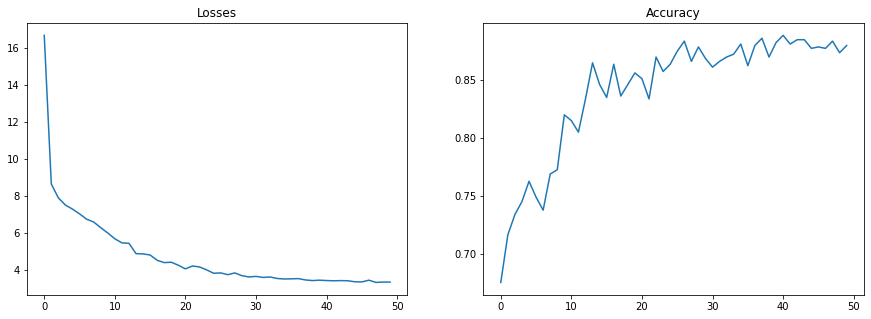

In [79]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

In [80]:
num_examples = 100
seq_len = 3
max_number = 10

inputs, targets = get_examples(seq_len, num_examples, max_number)

inputs = to_string(inputs, seq_len, max_number)
targets = to_string(targets, seq_len, max_number)

inputs = integer_encode(inputs, vocab)
targets = integer_encode(targets, vocab)

inputs, targets = Tensor(np.array(inputs).transpose((1, 0))), Tensor(np.array(targets).transpose((1, 0)))
outputs = model(inputs)
predicted = np.argmax(outputs.data, axis=1)

In [81]:
# gg_confusion_matrix(targets.data.reshape(-1), predicted)

In [82]:
def gradient_checker(J, grad_J, theta, eps=1e-5, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)
        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J)[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J[ix])))

        if rel_tol > rtol:
            print(f'num_grad: {num_grad} grad: {grad_J[ix]} factor: {grad_J[ix] / num_grad}')
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [83]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    original = model.parameters[idx].data.copy()
    np.copyto(dst=model.parameters[idx].data, src=theta)
    outputs = model(x)
    loss_value = loss_function(outputs, y).data
    np.copyto(dst=model.parameters[idx].data, src=original)
    model.zero_grad()
    return loss_value

In [84]:
def dJ_theta_global(model, loss_function, x, y):
    outputs = model(x)
    loss = loss_function(outputs, y)
    loss.backward()
    grads = []
    for parameter in model.parameters:
        grads.append(parameter.grad.copy())
    model.zero_grad()
    return grads

In [85]:
num_examples = 100
seq_len = 2
max_number = 10
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32

X_val, y_val = get_examples(seq_len, num_examples, max_number)
X_val, y_val = X_val.transpose(1, 0), y_val.transpose(1, 0)

In [86]:
loss_function = CrossEntropyLoss()
model_ = RecurrentNetwork(vocab_size, emb_size, hidden_size)
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start -- {parameter.__name__}')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start -- E
Gradient check passed
[0]: Elapsed time: 0.1s
[1]: Start -- weights
Gradient check passed
[1]: Elapsed time: 1.0s
[2]: Start -- bias
Gradient check passed
[2]: Elapsed time: 0.0s
[3]: Start -- weights
Gradient check passed
[3]: Elapsed time: 0.2s
[4]: Start -- bias
Gradient check passed
[4]: Elapsed time: 0.0s
Total elapsed time: 1.4s


# 1. LSTM

### Problem 1 (6.0)

Implement the LSTM cell class and use it in the RNN sorter. Don't forget to check gradients!

LSTM cell formulas:
$$
f_t=\sigma\Bigg(W_f\cdot\Big[h_{t-1};x_t\Big] + b_f\Bigg)\\
i_t = \sigma\Bigg(W_i\cdot\Big[h_{t-1};x_t\Big] + b_i\Bigg)\\
\tilde{c}_t = \tanh\Bigg(W_c\cdot\Big[h_{t-1};x_t\Big] + b_c\Bigg)\\
c_t = f_t \ast c_{t-1} + i_t \ast \tilde{c}_t\\
o_t = \sigma\Bigg(W_o\cdot\Big[h_{t-1};x_t\Big] + b_o\Bigg)\\
h_t = o_t \ast \tanh \left(c_t\right)
$$

As you can see, you'll need two additional functions here: sum and multiplication. You have to implement them too.

In [87]:
class MultiplyFunction(Function):
    def __init__(self, x1: Tensor, x2: Tensor):
        super().__init__()
        self.x1 = x1
        self.x2 = x2

    def __call__(self):
        return Tensor(np.multiply(self.x1.data, self.x2.data), func=self)

    def backward(self, grad: np.ndarray):
        self.x1.backward(np.multiply(grad, self.x2.data).reshape(self.x1.shape))
        self.x2.backward(np.multiply(grad, self.x1.data).reshape(self.x2.shape))

In [88]:
class Multiply(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: Tensor, x2: Tensor):
        return MultiplyFunction(x1, x2)()

In [89]:
class SumFunction(Function):
    def __init__(self, x1: Tensor, x2: Tensor):
        super().__init__()
        self.x1 = x1
        self.x2 = x2

    def __call__(self):
        return Tensor(self.x1.data + self.x2.data, func=self)

    def backward(self, grad: np.ndarray):
        self.x1.backward(grad.reshape(self.x1.shape))
        self.x2.backward(grad.reshape(self.x2.shape))

In [90]:
class Sum(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: Tensor, x2: Tensor):
        return SumFunction(x1, x2)()

In [91]:
class LSTMCell(Module):

    def __init__(self, state_size: int, hidden_size: int):
        super().__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size

        self.layer_f = LinearLayer(self.state_size, self.hidden_size)
        self.layer_i = LinearLayer(self.state_size, self.hidden_size)
        self.layer_c = LinearLayer(self.state_size, self.hidden_size)
        self.layer_o = LinearLayer(self.state_size, self.hidden_size)

        self.register_parameters([self.layer_f, self.layer_i, self.layer_c, self.layer_o])

        self.function_f = SigmoidFunction()
        self.function_i = SigmoidFunction()
        self.function_c = TanhFunction()
        self.function_o = SigmoidFunction()
        self.function_h = TanhFunction()

        self.multiply_c1 = Multiply()
        self.multiply_c2 = Multiply()
        self.multiply_h = Multiply()

        self.sum = Sum()

        self.hstack = HStack()

    def forward(self, x: Tensor, h_t_1: Tensor, c_t_1: Tensor):
        X = self.hstack(h_t_1, x)

        f_result = self.function_f(self.layer_f(X))
        i_result = self.function_i(self.layer_i(X))
        c_result = self.function_c(self.layer_c(X))
        o_result = self.function_o(self.layer_o(X))

        result_c = self.sum(self.multiply_c1(f_result, c_t_1), self.multiply_c2(i_result, c_result))
        result_h = self.multiply_h(o_result, self.function_h(result_c))

        return result_h, result_c

In [92]:
class LSTM(Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm_cell = LSTMCell(self.input_size + self.hidden_size, self.hidden_size)

        self.register_parameters([self.lstm_cell])

        self.vstack = VStack()
        self.row = Row()

    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None, c_t_1: Optional[Tensor] = None):
        batch_size = x.shape[1]
        h = Tensor (np.zeros((0, batch_size, self.hidden_size)), name="h")

        h_t_1 = h_t_1 if h_t_1 is not None else Tensor(np.zeros((batch_size, self.hidden_size)), name="h_t_1")
        c_t_1 = c_t_1 if c_t_1 is not None else Tensor(np.zeros((batch_size, self.hidden_size)), name="c_t_1")

        for idx in range(seq_len):
            h_t_1, c_t_1 = self.lstm_cell.forward(self.row(x, idx), h_t_1, c_t_1)
            h = self.vstack(h, h_t_1.reshape((1, batch_size, self.hidden_size)))

        return h

# Adam

In [93]:
class Adam(Optimizer):
    def __init__(self, params: List[Tensor], alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        super().__init__(params, alpha)
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
        self.m = None
        self.v = None

    def step(self):
        pass

# Checks

# Checks
Change RNN to LSTM in the RecurrentNetwork class below to perform gradient check.
Note, that due to naive implementation of the backpropagation, number of calculations needed for one backpropagation pass grows exponentially with respect to sequence length. That's why the length in the gradient check is set to 2.

$\color{red}{\text{If you want to implement a faster version of numpy framework, which supports recurrent arcgitectures, you can take this task as a course project.}}$

In [94]:
class RecurrentNetwork(Module):
    def __init__(self, vocab_size: int, emb_size: int, hidden_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.embedding = Embedding(vocab_size, emb_size)
        self.lstm = LSTM(emb_size, hidden_size)
        self.linear = LinearLayer(hidden_size, vocab_size)
        xavier_(self.linear.parameters)
        self.register_parameters([self.embedding, self.lstm, self.linear])

    def forward(self, x: Tensor):
        emb = self.embedding(x)
        lstm_out = self.lstm(emb)
        linear_out = self.linear(lstm_out.reshape(-1, self.hidden_size))
        return linear_out

In [95]:
def gradient_checker(J, grad_J, theta, eps=1e-5, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])
    calls = 0 
    while not it.finished:
        ix = it.multi_index
        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)
        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)
        calls += 1
        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J)[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J[ix])))

        if rel_tol > rtol:
            print(f'num_grad: {num_grad} grad: {grad_J[ix]} factor: {grad_J[ix] / num_grad}')
            print(f'Incorrect gradient for the axis {str(ix)}')
            print(f'calls: {calls}')
            return
        it.iternext()
    print(f'Gradient check passed. Calls: {calls}')

In [96]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    original = model.parameters[idx].data.copy()
    np.copyto(dst=model.parameters[idx].data, src=theta)
    outputs = model(x)
    loss_value = loss_function(outputs, y).data
    np.copyto(dst=model.parameters[idx].data, src=original)
    model.zero_grad()
    return loss_value

In [97]:
def dJ_theta_global(model, loss_function, x, y):
    outputs = model(x)
    loss = loss_function(outputs, y)
    loss.backward()
    grads = []
    for parameter in model.parameters:
        grads.append(parameter.grad.copy())
    model.zero_grad()
    return grads

In [98]:
# original - passes test
num_examples = 100
seq_len = 2
max_number = 10
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32

X_val, y_val = get_examples(seq_len, num_examples, max_number)
X_val, y_val = X_val.transpose(1, 0), y_val.transpose(1, 0)

In [99]:
loss_function = CrossEntropyLoss()
model_ = RecurrentNetwork(vocab_size, emb_size, hidden_size)
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start -- {parameter.__name__}')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start -- E
Gradient check passed. Calls: 240
[0]: Elapsed time: 0.3s
[1]: Start -- weights
Gradient check passed. Calls: 1664
[1]: Elapsed time: 2.3s
[2]: Start -- bias
Gradient check passed. Calls: 32
[2]: Elapsed time: 0.0s
[3]: Start -- weights
Gradient check passed. Calls: 1664
[3]: Elapsed time: 3.1s
[4]: Start -- bias
Gradient check passed. Calls: 32
[4]: Elapsed time: 0.0s
[5]: Start -- weights
Gradient check passed. Calls: 1664
[5]: Elapsed time: 2.3s
[6]: Start -- bias
Gradient check passed. Calls: 32
[6]: Elapsed time: 0.0s
[7]: Start -- weights
Gradient check passed. Calls: 1664
[7]: Elapsed time: 2.4s
[8]: Start -- bias
Gradient check passed. Calls: 32
[8]: Elapsed time: 0.0s
[9]: Start -- weights
Gradient check passed. Calls: 384
[9]: Elapsed time: 0.5s
[10]: Start -- bias
Gradient check passed. Calls: 12
[10]: Elapsed time: 0.0s
Total elapsed time: 11.2s


# 2. Distillation

# Problem 2 (6.0) Model Distillation

На лекции мы упоминали Model Distillation в контексте DistillBert от HuggingFace. В этом задании вам предлагается применить дистилляцию к произвольной модели и попробовать добиться сокращения размера модели-ученика при почти полном сохранении качества по сравнению с моделью-учителем.

Посмотрите следующее [руководство](https://habr.com/ru/company/avito/blog/485290/) и попробуйте применить описанные идеи к какой-либо модели. Не обязательно брать BERT, вполне подойдет BiLSTM или что-то подобное, для чего известны метрики на каком-либо датасете.

Ссылки на GitHub или Colab c решением размещайте на этой странице. 

# DUE DATE

# The due date is 22 of December 2021 23:59:59

## Instructions

* To submit the assignment share your workbook to me (with **Can edit** access rights).

* Check, that you found all the tasks in the workbook.  